# Sugarcane Leaf Disease Classification

This notebook implements a lightweight CNN model to classify sugarcane leaf images into six categories: Healthy, Bacterial Blight, Mosaic, RedRot, Rust, Yellow.

## Import Libraries

In [2]:
%pip install tensorflow
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

Note: you may need to restart the kernel to use updated packages.


## Data Loading and Preprocessing

In [3]:
# Set parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_DIR = 'Sugarcane_leafs'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Validation data generator
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training generator
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Class labels
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)

Found 15943 images belonging to 6 classes.
Found 3983 images belonging to 6 classes.
Classes: ['BacterialBlights', 'Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']


## Model Building

In [4]:
# Load MobileNetV2 base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training

In [5]:
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
499/499 ━━━━━━━━━━━━━━━━━━━━ 1076s 2s/step - accuracy: 0.6258 - loss: 0.9849 - val_accuracy: 0.7881 - val_loss: 0.5853
Epoch 2/30
499/499 ━━━━━━━━━━━━━━━━━━━━ 456s 913ms/step - accuracy: 0.7124 - loss: 0.7638 - val_accuracy: 0.8232 - val_loss: 0.5007
Epoch 3/30
499/499 ━━━━━━━━━━━━━━━━━━━━ 463s 928ms/step - accuracy: 0.7389 - loss: 0.6974 - val_accuracy: 0.8366 - val_loss: 0.4691
Epoch 4/30
499/499 ━━━━━━━━━━━━━━━━━━━━ 496s 993ms/step - accuracy: 0.7488 - loss: 0.6674 - val_accuracy: 0.8187 - val_loss: 0.5365
Epoch 5/30
499/499 ━━━━━━━━━━━━━━━━━━━━ 363s 727ms/step - accuracy: 0.7527 - loss: 0.6562 - val_accuracy: 0.8433 - val_loss: 0.4501
Epoch 6/30
499/499 ━━━━━━━━━━━━━━━━━━━━ 312s 625ms/step - accuracy: 0.7648 - loss: 0.6212 - val_accuracy: 0.8684 - val_loss: 0.3707
Epoch 7/30
499/499 ━━━━━━━━━━━━━━━━━━━━ 317s 615ms/step - accuracy: 0.7722 - loss: 0.6081 - val_accuracy: 0.8554 - val_loss: 0.4075
Epoch 8/30
499/499 ━━━━━━━━━━━━━━━━━━━━ 333s 667ms/step - accuracy: 0.7711 - l

## Evaluation

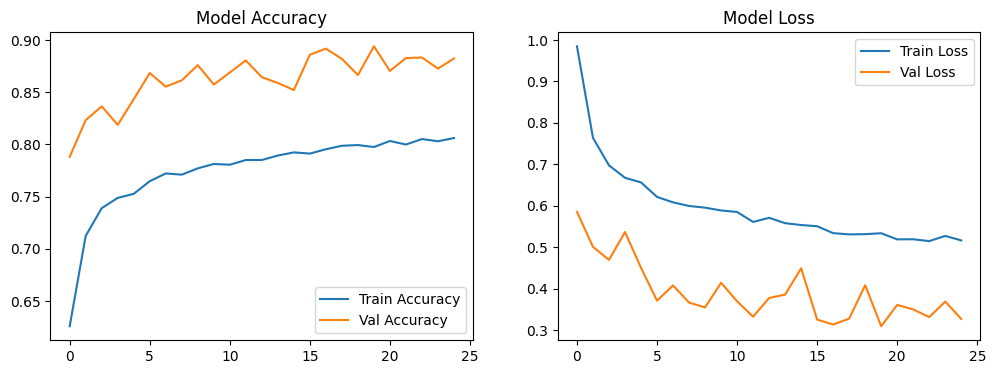

125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - accuracy: 0.8940 - loss: 0.3089
Validation Loss: 0.3089
Validation Accuracy: 0.8940
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 350ms/step
                  precision    recall  f1-score   support

BacterialBlights       0.25      0.23      0.24       960
         Healthy       0.16      0.19      0.17       626
          Mosaic       0.16      0.13      0.14       554
          RedRot       0.14      0.15      0.15       621
            Rust       0.14      0.14      0.14       616
          Yellow       0.14      0.14      0.14       606

        accuracy                           0.17      3983
       macro avg       0.16      0.16      0.16      3983
    weighted avg       0.17      0.17      0.17      3983



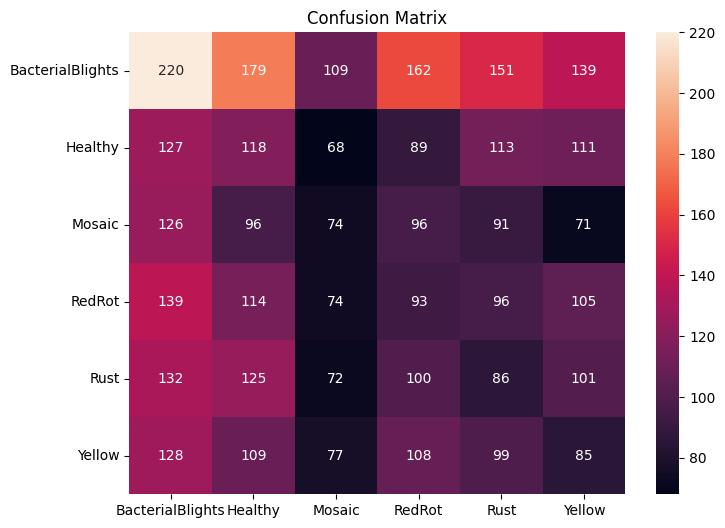

In [6]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

# Evaluate on validation set
val_loss, val_acc = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

# Predictions
validation_generator.reset()
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('sugarcane_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\joe-an\AppData\Local\Temp\tmprkmri81h\assets


INFO:tensorflow:Assets written to: C:\Users\joe-an\AppData\Local\Temp\tmprkmri81h\assets


Saved artifact at 'C:\Users\joe-an\AppData\Local\Temp\tmprkmri81h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2243772757968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2243772759888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2243772759312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2243772759696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2243772759504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2243772758160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2243773661264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2243773662992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2243773662800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2243773661840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2243

## Testing Inference with TFLite

In [8]:
# Test TFLite model with a sample image
from tensorflow import lite as tflite
from tensorflow.keras.preprocessing import image
import numpy as np

# Load TFLite model
interpreter = tflite.Interpreter(model_path='sugarcane_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load a sample image (replace with actual path)
sample_img_path = 'Sugarcane_leafs/Healthy/cropped_healthy (1).jpeg'  # Adjust path to an existing image
img = image.load_img(sample_img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Run inference
interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

# Get prediction
predicted_index = np.argmax(output)
predicted_class = class_names[predicted_index]
confidence = output[0][predicted_index]

print(f'Predicted Class: {predicted_class}')
print(f'Confidence: {confidence:.4f}')
print(f'All Probabilities: {output[0]}')

Predicted Class: Healthy
Confidence: 0.9065
All Probabilities: [1.7294451e-06 9.0645200e-01 5.1173143e-02 8.0148075e-03 3.1306744e-02
 3.0515401e-03]


c:\Users\joe-an\Desktop\Joshua\projects\Bigdata\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
